# Scenario
- This experiment's goal is to investigate in machine learning model performance on how good they are able to identify people who are smoking. Furthermore, it is also going to be cleared which factor(s) will have more effect on model's prediction.
- In medical industry, such system can be helpful to identify patients who are smoking. This will help doctors to have a broader knowledge and view to treat with the patient. 
- This experiment is counted as a small part of the information gain system to be used in the medical industry.
- Such system will be useful in emergency situations where there is no available information about the patient. 

# Plan
- Reading data and understanding data
- Implementation of preprocessing steps
    * Dropping unnecessary columns
    * Separating features from the column that indicates person status
    * Encoding variables that contain categorical values (such as M(Male) or F(Female))
    * Using labeling method for the target column
    * Splitting data into train and test sets
        * Shuffling, stratifying, test_size = 20%
    * Scaling data
        * MinMaxScalar
- Training models
    * Using lazypredict to get overview of models' performances
    * Selecting models
    * Hyper-parameter tuning
    * Models performance discussion
- Conclusion

# Necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

In [2]:
# the value of the following variable is used in n_jobs parameter.
CPU_KILLER = -1

# Functions

In [3]:
# Function to print line of stars
def print_stars(n=30):
    print('*' * n)

In [4]:
# Function to calculate multiple evaluation metrics
def evaluation_metrics(true_label, pred_label):
    evals = dict()
    
    # Accuracy
    evals['Accuracy'] = round(accuracy_score(true_label, pred_label), 3)
    # Balanced accuracy
    evals['Balanced accuracy'] = round(balanced_accuracy_score(true_label, pred_label), 3)
    # F1 score
    evals['F1 score'] = round(f1_score(true_label, pred_label), 3)
    # Precision score
    evals['Precision'] = round(precision_score(true_label, pred_label), 3)
    # Recall score
    evals['Recall'] = round(recall_score(true_label, pred_label), 3)
    
    return evals

In [5]:
# Function to plot distribution of classes
def plot_distribution(data, title='Distribution of classes in the dataset', type="percent"):
    if type ==  'percent':
        # Function to calculate the distribution of classes in dataset
        def calculate_distr(value, data):
            return data.value_counts()[value]/(data.value_counts()[0] + data.value_counts()[1]) * 100

        ax = sns.barplot(pd.DataFrame({'None Somker': [calculate_distr(0, data)], 'Smoker': [calculate_distr(1, data)]}))
        ax.bar_label(ax.containers[0], label_type='edge')
        ax.set(title=title)

    elif type == 'actual':
        ax = sns.barplot(pd.DataFrame({'None Smoker': [data.value_counts()[0]], 'Smoker': [data.value_counts()[1]]}))
        ax.bar_label(ax.containers[0], label_type='edge')
        ax.set(title=title)
    
    else:
        raise "Wrong input"
        
    return ax

In [6]:
def make_pipe(estimator, scalar):
    return Pipeline([('scalar', scalar), ('estimator', estimator)])

In [7]:
# Function for hyper parameters tuning using GridSearchCV
def hyper_params(estimator, params, features, labels, indicator='f1_macro'):
    if indicator in ['accuracy', 'balanced_accuracy', 'f1_macro', 'recall', 'precision']:
        estimator.fit(features, labels)
        grid = GridSearchCV(estimator=estimator, 
                            param_grid=params, 
                            scoring=['accuracy', 'balanced_accuracy', 'f1_macro', 'recall', 'precision'], 
                            cv=4,
                            n_jobs=CPU_KILLER,
                            refit=indicator,
                            verbose=1)
        grid = grid.fit(features, labels)

        print("Best Parameters: ", grid.best_params_)
        print(f"Best Score ({indicator}): ", grid.best_score_)

        data = pd.DataFrame().from_dict(grid.cv_results_)
        data = data[[x for x in data.columns if x.lower()[:5] != 'split']].iloc[:, 4:].drop('params', axis=1)

    else:
        raise "Indicator must be one of the ('accuracy', 'balanced_accuracy', 'f1_macro', 'recall', 'precision')"

    return grid, data

In [8]:
# Function to create Confusion Matrix
def confusion_plot(true_label, pred_label, model, title="Confusion Matrix"):
    cm = confusion_matrix(true_label, pred_label, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Smoker', 'Smoker'])
    disp.plot()
    disp.ax_.set_title(title)

* Data is scaled using MinMaxScalar() in the pipeline designed in the above function (make_prediction()). Since there is no negative value in the dataset, the range of values will be between 0 and 1. 
* Scaling affects the learning process of the classifier and reduces the time it takes for the model to be trained (in our case it reduced training time by 0.3 minutes).


# Reading data

- Dataset is downloaded from Kaggle website (https://www.kaggle.com/datasets/kukuroo3/body-signal-of-smoking). However the publisher of the dataset on Kaggle implemented some preprocessing on the dataset. The original dataset is made available in the government of Korea website (https://www.data.go.kr/data/15007122/fileData.do). Dataset is available without any restrictions and it is available free of charge. [1]

In [9]:
data = pd.read_csv("./smoking.csv")
data

,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,0,F,40,155,60,81.30,1.20,1.00,1.00,1.00,...,12.90,1.00,0.70,18.00,19.00,27.00,Y,0,Y,0
1,1,F,40,160,60,81.00,0.80,0.60,1.00,1.00,...,12.70,1.00,0.60,22.00,19.00,18.00,Y,0,Y,0
2,2,M,55,170,60,80.00,0.80,0.80,1.00,1.00,...,15.80,1.00,1.00,21.00,16.00,22.00,Y,0,N,1
3,3,M,40,165,70,88.00,1.50,1.50,1.00,1.00,...,14.70,1.00,1.00,19.00,26.00,18.00,Y,0,Y,0
4,4,F,40,155,60,86.00,1.00,1.00,1.00,1.00,...,12.50,1.00,0.60,16.00,14.00,22.00,Y,0,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55687,55676,F,40,170,65,75.00,0.90,0.90,1.00,1.00,...,12.30,1.00,0.60,14.00,7.00,10.00,Y,1,Y,0
55688,55681,F,45,160,50,70.00,1.20,1.20,1.00,1.00,...,14.00,1.00,0.90,20.00,12.00,14.00,Y,0,Y,0
55689,55683,F,55,160,50,68.50,1.00,1.20,1.00,1.00,...,12.40,1.00,0.50,17.00,11.00,12.00,Y,0,N,0
55690,55684,M,60,165,60,78.00,0.80,1.00,1.00,1.00,...,14.40,1.00,0.70,20.00,19.00,18.00,Y,0,N,0


# Understanding data

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   55692 non-null  int64  
 1   gender               55692 non-null  object 
 2   age                  55692 non-null  int64  
 3   height(cm)           55692 non-null  int64  
 4   weight(kg)           55692 non-null  int64  
 5   waist(cm)            55692 non-null  float64
 6   eyesight(left)       55692 non-null  float64
 7   eyesight(right)      55692 non-null  float64
 8   hearing(left)        55692 non-null  float64
 9   hearing(right)       55692 non-null  float64
 10  systolic             55692 non-null  float64
 11  relaxation           55692 non-null  float64
 12  fasting blood sugar  55692 non-null  float64
 13  Cholesterol          55692 non-null  float64
 14  triglyceride         55692 non-null  float64
 15  HDL                  55692 non-null 

In [11]:
object_columns = (data.select_dtypes(include=['object']).columns)
for column in object_columns:
    print(data.loc[:, column].value_counts())
    print_stars()

M    35401
F    20291
Name: gender, dtype: int64
******************************
Y    55692
Name: oral, dtype: int64
******************************
Y    30940
N    24752
Name: tartar, dtype: int64
******************************


* There are 3 columns in the dataset that contain non-numerical values.
* These columns contain values as character. Therefore, encoding must be applied on them.
* 'oral' column contains only one value (Y) which is not useful.

In [12]:
data.columns

Index(['ID', 'gender', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)',
       'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)',
       'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol',
       'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein',
       'serum creatinine', 'AST', 'ALT', 'Gtp', 'oral', 'dental caries',
       'tartar', 'smoking'],
      dtype='object')

* Explanations about some features:
    * systolic and relaxation values are calculated using Blood pressure. systolic blood pressure is the blood pressure on the artery when heart pumps the blood.
    * HDL and LDL are cholesterol types. LDL (Low-density lipoprotein cholesterol) is the bad cholesterol type that can end up narrowing blood vessels. HDL (High-density lipoprotein cholesterol) is the good cholesterol type. This type goes to the liver and then removed from body.
    * AST and ALT are enzymes that determine how well the liver is functioning. The higher the value shows that liver has a problem.
    * GTP is the test result to indicate how well the liver functions. The higher the value, shows that the liver has problem.


In [13]:
data.describe()

,ID,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,55692.00,55692.00,55692.00,55692.00,55692.00,55692.00,55692.00,55692.00,55692.00,55692.00,...,55692.00,55692.00,55692.00,55692.00,55692.00,55692.00,55692.00,55692.00,55692.00,55692.00
mean,27845.50,44.18,164.65,65.86,82.05,1.01,1.01,1.03,1.03,121.49,...,57.29,114.96,14.62,1.09,0.89,26.18,27.04,39.95,0.21,0.37
std,16077.04,12.07,9.19,12.82,9.27,0.49,0.49,0.16,0.16,13.68,...,14.74,40.93,1.56,0.40,0.22,19.36,30.95,50.29,0.41,0.48
min,0.00,20.00,130.00,30.00,51.00,0.10,0.10,1.00,1.00,71.00,...,4.00,1.00,4.90,1.00,0.10,6.00,1.00,1.00,0.00,0.00
25%,13922.75,40.00,160.00,55.00,76.00,0.80,0.80,1.00,1.00,112.00,...,47.00,92.00,13.60,1.00,0.80,19.00,15.00,17.00,0.00,0.00
50%,27845.50,40.00,165.00,65.00,82.00,1.00,1.00,1.00,1.00,120.00,...,55.00,113.00,14.80,1.00,0.90,23.00,21.00,25.00,0.00,0.00
75%,41768.25,55.00,170.00,75.00,88.00,1.20,1.20,1.00,1.00,130.00,...,66.00,136.00,15.80,1.00,1.00,28.00,31.00,43.00,0.00,1.00
max,55691.00,85.00,190.00,135.00,129.00,9.90,9.90,2.00,2.00,240.00,...,618.00,1860.00,21.10,6.00,11.60,1311.00,2914.00,999.00,1.00,1.00


- Dataset contains 27 variables with 55692 samples of data.
- There are three variables contains non-numerical values (gender, oral, and tartar) which we need to encode them.
- Column named as smoking is the target column which identifies whether the person is a smoker or not.
- Column ID can be simply removed. Since it is just an indicator for the person.

Is the data imbalanced?

<AxesSubplot: title={'center': 'Distribution of classes in the dataset'}>

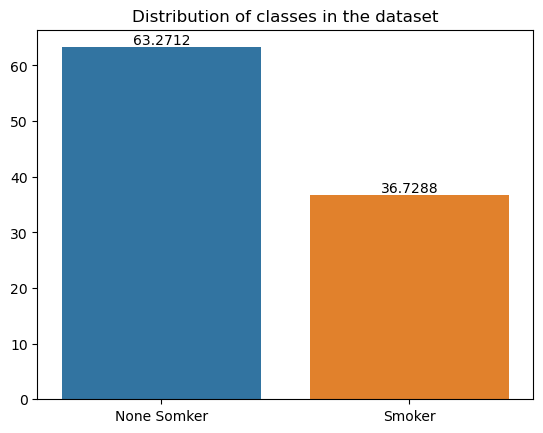

In [14]:
plot_distribution(data.smoking)
# ax = sns.barplot(pd.DataFrame({'0': [calculate_distr(0, data)], '1': [calculate_distr(1, data)]}))
# ax.bar_label(ax.containers[0], label_type='edge')
# ax.set(title='Distribution of classes in the dataset')

- As shown in the above plot, class '1' contains only 36.7 percent of the all dataset. This shows that dataset in imbalanced. Since the minor class (class '1') distribution is between 20-40 percent, then it dataset can be mentioned as 'Mild' imbalanced dataset. Therefore, we should consider this fact that accuracy of the model might not be a good performance evaluation alone. 
    - reference: (https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data)

# Data Preprocessing

In [15]:
# Finding columns contain only one type of value
columns_to_drop = ['ID']
for column in data.columns:
    if len(data.loc[:,column].value_counts()) == 1:
        columns_to_drop.append(column)
columns_to_drop

['ID', 'oral']

- Column Oral, contains only value of 'y'. Therefore, we can also exclude this column from the experiment along the ID column
- In the following code block, the mentioned columns will be dropped from the experiment. Also, for ease of coding, all the column names are changed to lowercase.


In [16]:
# dropping the column ID
data = data.drop(labels=columns_to_drop, axis=1)
# lowercasing the column names
data.columns = data.columns.str.lower()
data

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,ldl,hemoglobin,urine protein,serum creatinine,ast,alt,gtp,dental caries,tartar,smoking
0,F,40,155,60,81.30,1.20,1.00,1.00,1.00,114.00,...,126.00,12.90,1.00,0.70,18.00,19.00,27.00,0,Y,0
1,F,40,160,60,81.00,0.80,0.60,1.00,1.00,119.00,...,127.00,12.70,1.00,0.60,22.00,19.00,18.00,0,Y,0
2,M,55,170,60,80.00,0.80,0.80,1.00,1.00,138.00,...,151.00,15.80,1.00,1.00,21.00,16.00,22.00,0,N,1
3,M,40,165,70,88.00,1.50,1.50,1.00,1.00,100.00,...,226.00,14.70,1.00,1.00,19.00,26.00,18.00,0,Y,0
4,F,40,155,60,86.00,1.00,1.00,1.00,1.00,120.00,...,107.00,12.50,1.00,0.60,16.00,14.00,22.00,0,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55687,F,40,170,65,75.00,0.90,0.90,1.00,1.00,110.00,...,118.00,12.30,1.00,0.60,14.00,7.00,10.00,1,Y,0
55688,F,45,160,50,70.00,1.20,1.20,1.00,1.00,101.00,...,79.00,14.00,1.00,0.90,20.00,12.00,14.00,0,Y,0
55689,F,55,160,50,68.50,1.00,1.20,1.00,1.00,117.00,...,63.00,12.40,1.00,0.50,17.00,11.00,12.00,0,N,0
55690,M,60,165,60,78.00,0.80,1.00,1.00,1.00,133.00,...,146.00,14.40,1.00,0.70,20.00,19.00,18.00,0,N,0


Seprating features columns from target column

In [17]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,hdl,ldl,hemoglobin,urine protein,serum creatinine,ast,alt,gtp,dental caries,tartar
0,F,40,155,60,81.30,1.20,1.00,1.00,1.00,114.00,...,73.00,126.00,12.90,1.00,0.70,18.00,19.00,27.00,0,Y
1,F,40,160,60,81.00,0.80,0.60,1.00,1.00,119.00,...,42.00,127.00,12.70,1.00,0.60,22.00,19.00,18.00,0,Y
2,M,55,170,60,80.00,0.80,0.80,1.00,1.00,138.00,...,55.00,151.00,15.80,1.00,1.00,21.00,16.00,22.00,0,N
3,M,40,165,70,88.00,1.50,1.50,1.00,1.00,100.00,...,45.00,226.00,14.70,1.00,1.00,19.00,26.00,18.00,0,Y
4,F,40,155,60,86.00,1.00,1.00,1.00,1.00,120.00,...,62.00,107.00,12.50,1.00,0.60,16.00,14.00,22.00,0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55687,F,40,170,65,75.00,0.90,0.90,1.00,1.00,110.00,...,75.00,118.00,12.30,1.00,0.60,14.00,7.00,10.00,1,Y
55688,F,45,160,50,70.00,1.20,1.20,1.00,1.00,101.00,...,73.00,79.00,14.00,1.00,0.90,20.00,12.00,14.00,0,Y
55689,F,55,160,50,68.50,1.00,1.20,1.00,1.00,117.00,...,79.00,63.00,12.40,1.00,0.50,17.00,11.00,12.00,0,N
55690,M,60,165,60,78.00,0.80,1.00,1.00,1.00,133.00,...,48.00,146.00,14.40,1.00,0.70,20.00,19.00,18.00,0,N


In [18]:
y

0        0
1        0
2        1
3        0
4        0
        ..
55687    0
55688    0
55689    0
55690    0
55691    1
Name: smoking, Length: 55692, dtype: int64

* All the feature columns are now stored in variable X and the actual target column , which indicates whether the person is smoker or not, is stored in variable y separately.

Encoding categorical variables

In [19]:
old_columns = X.columns
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0, -1])], remainder='passthrough')
X = pd.DataFrame(ct.fit_transform(X))
X

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1.00,0.00,0.00,1.00,40.00,155.00,60.00,81.30,1.20,1.00,...,82.00,73.00,126.00,12.90,1.00,0.70,18.00,19.00,27.00,0.00
1,1.00,0.00,0.00,1.00,40.00,160.00,60.00,81.00,0.80,0.60,...,115.00,42.00,127.00,12.70,1.00,0.60,22.00,19.00,18.00,0.00
2,0.00,1.00,1.00,0.00,55.00,170.00,60.00,80.00,0.80,0.80,...,182.00,55.00,151.00,15.80,1.00,1.00,21.00,16.00,22.00,0.00
3,0.00,1.00,0.00,1.00,40.00,165.00,70.00,88.00,1.50,1.50,...,254.00,45.00,226.00,14.70,1.00,1.00,19.00,26.00,18.00,0.00
4,1.00,0.00,1.00,0.00,40.00,155.00,60.00,86.00,1.00,1.00,...,74.00,62.00,107.00,12.50,1.00,0.60,16.00,14.00,22.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55687,1.00,0.00,0.00,1.00,40.00,170.00,65.00,75.00,0.90,0.90,...,99.00,75.00,118.00,12.30,1.00,0.60,14.00,7.00,10.00,1.00
55688,1.00,0.00,0.00,1.00,45.00,160.00,50.00,70.00,1.20,1.20,...,69.00,73.00,79.00,14.00,1.00,0.90,20.00,12.00,14.00,0.00
55689,1.00,0.00,1.00,0.00,55.00,160.00,50.00,68.50,1.00,1.20,...,77.00,79.00,63.00,12.40,1.00,0.50,17.00,11.00,12.00,0.00
55690,0.00,1.00,1.00,0.00,60.00,165.00,60.00,78.00,0.80,1.00,...,79.00,48.00,146.00,14.40,1.00,0.70,20.00,19.00,18.00,0.00


Bringing back the column names and assigning appropriate name for new columns created by encoder

In [20]:
X.columns = old_columns[1:-1].insert(0, ['female', 'male', 'tartar_n', 'tartar_y'])
X

,female,male,tartar_n,tartar_y,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),...,triglyceride,hdl,ldl,hemoglobin,urine protein,serum creatinine,ast,alt,gtp,dental caries
0,1.00,0.00,0.00,1.00,40.00,155.00,60.00,81.30,1.20,1.00,...,82.00,73.00,126.00,12.90,1.00,0.70,18.00,19.00,27.00,0.00
1,1.00,0.00,0.00,1.00,40.00,160.00,60.00,81.00,0.80,0.60,...,115.00,42.00,127.00,12.70,1.00,0.60,22.00,19.00,18.00,0.00
2,0.00,1.00,1.00,0.00,55.00,170.00,60.00,80.00,0.80,0.80,...,182.00,55.00,151.00,15.80,1.00,1.00,21.00,16.00,22.00,0.00
3,0.00,1.00,0.00,1.00,40.00,165.00,70.00,88.00,1.50,1.50,...,254.00,45.00,226.00,14.70,1.00,1.00,19.00,26.00,18.00,0.00
4,1.00,0.00,1.00,0.00,40.00,155.00,60.00,86.00,1.00,1.00,...,74.00,62.00,107.00,12.50,1.00,0.60,16.00,14.00,22.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55687,1.00,0.00,0.00,1.00,40.00,170.00,65.00,75.00,0.90,0.90,...,99.00,75.00,118.00,12.30,1.00,0.60,14.00,7.00,10.00,1.00
55688,1.00,0.00,0.00,1.00,45.00,160.00,50.00,70.00,1.20,1.20,...,69.00,73.00,79.00,14.00,1.00,0.90,20.00,12.00,14.00,0.00
55689,1.00,0.00,1.00,0.00,55.00,160.00,50.00,68.50,1.00,1.20,...,77.00,79.00,63.00,12.40,1.00,0.50,17.00,11.00,12.00,0.00
55690,0.00,1.00,1.00,0.00,60.00,165.00,60.00,78.00,0.80,1.00,...,79.00,48.00,146.00,14.40,1.00,0.70,20.00,19.00,18.00,0.00


* As mentioned earlier, in data understanding, variables 'gender', and 'tartar' are now encoded.
* We have used one hot encoding to encode these variables. This resulted in creation of new column for each value type in the column. 
* There is another choice of encoding which is called "OrdinalEncoding". However, it is not suitable to be used here. The reason is that there is no numerical order between the values. Therefore, it is not useful in this case.


In [21]:
le = LabelEncoder()
y = pd.Series(le.fit_transform(y))
y

0        0
1        0
2        1
3        0
4        0
        ..
55687    0
55688    0
55689    0
55690    0
55691    1
Length: 55692, dtype: int64

* For the target column, LabelEncoder is used to convert the characters (y/n) to 0 and 1.

Splitting dataset into train set and test set

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=1)

<AxesSubplot: title={'center': 'Number of samples per each gender and smoking status'}, xlabel='gender,smoking', ylabel='Number of Samples'>

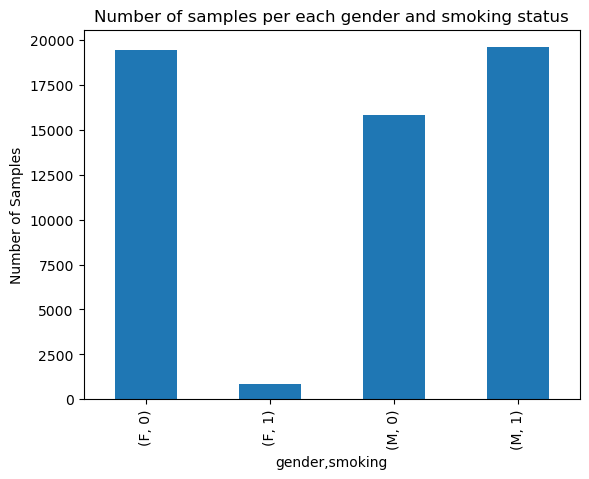

In [23]:
(data.groupby(['gender', 'smoking']).size()).plot(kind='bar', 
                                                        title='Number of samples per each gender and smoking status',
                                                        ylabel='Number of Samples')

* By looking at the graph above, we can see that there is an unequal distribution of the smokers and none smokers based on the gender in the dataset. 

<AxesSubplot: title={'center': 'Distribution of classes in TRAIN set (Total = 44553)'}>

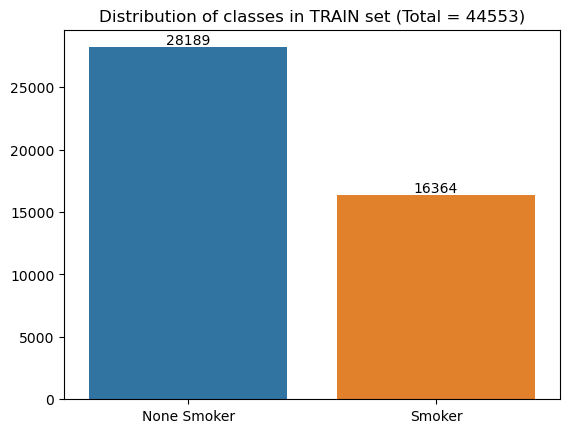

In [24]:
plot_distribution(y_train, title=f"Distribution of classes in TRAIN set (Total = {y_train.value_counts()[0]+y_train.value_counts()[1]})", type='actual')

<AxesSubplot: title={'center': 'Distribution of classes in TEST set (Total = 11139)'}>

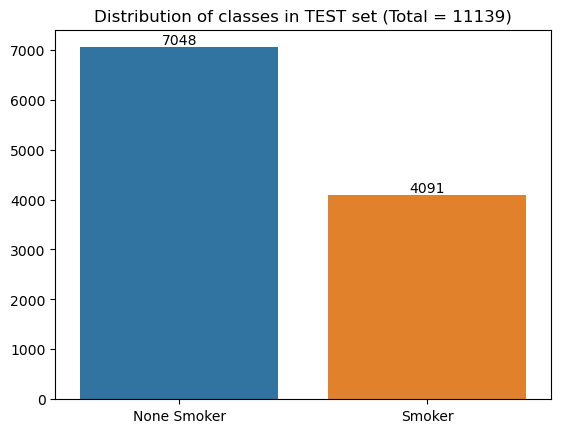

In [25]:
plot_distribution(y_test, 
    title=f"Distribution of classes in TEST set (Total = {y_test.value_counts()[0]+y_test.value_counts()[1]})", type='actual')

* Splitting data has been done by applying following methods:
    - Shuffling: to minimize the chance of getting all same classes in train or test set.
    - Stratify: an important factor to consider when dealing with imbalance dataset. It will make sure the proportion of values in the train set or test set are kept same.
    - random_state: is set to 1 to make the experiment reproducible 
    - finally, there are 20% of data assigned for testing and 80% for training
* The above plots also shows how many data from each class is included for the training and testing. Distribution percentage is same as what we had for the overall dataset. This is because of using stratify

## Data Standardization

In [26]:
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

* Standardization is implemented to convert data into range of 0 to 1. 
* It does not have effect on some machine learning models such as Random Forest, but for the other models it definitely results in better model learning.

# Models and results

## Models performance overview (Lazy Classifier) [2]

    CAUTION: Code blocks with "caution sign" on top will take longer time to finish running. Please be patient when re-running the code.

In [27]:
lazy_x_train, lazy_x_test, lazy_y_train, lazy_y_test = train_test_split(X_train, 
                                                                        y_train, 
                                                                        test_size=0.2, 
                                                                        shuffle=True, 
                                                                        stratify=y_train, 
                                                                        random_state=1)
lazy_clf = LazyClassifier(verbose=0, custom_metric=None, predictions=True)
lazy_res, lazy_pred = lazy_clf.fit(lazy_x_train, lazy_x_test, lazy_y_train, lazy_y_test)
lazy_res

100%|██████████| 29/29 [02:59<00:00,  6.18s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.82,0.81,0.81,0.82,5.36
ExtraTreesClassifier,0.81,0.80,0.80,0.81,3.16
BaggingClassifier,0.80,0.77,0.77,0.79,2.37
XGBClassifier,0.78,0.77,0.77,0.78,0.69
LGBMClassifier,0.77,0.76,0.76,0.77,0.24
SVC,0.76,0.75,0.75,0.77,47.41
NuSVC,0.77,0.75,0.75,0.77,82.69
AdaBoostClassifier,0.76,0.75,0.75,0.76,1.60
DecisionTreeClassifier,0.77,0.75,0.75,0.76,0.40


* Before jumping into the training and evaluating actual models, it is necessary to remind that our dataset is imbalanced. 
* Imbalanced datasets needs to have more attention to the prediction evaluation. 
* At this point accuracy of the model alone, is not a good evaluator of the model performance. Therefore, we will consider F1-Score in the evaluation and accuracy beside it.
* F1 score, makes sure data that classifier does not predict all samples from a single class.
* F1 score value is between 0 and 1. The closer value to 1, means the model performance is better
$$f1(C_i)=\frac{2}{\frac{1}{precision(C_i)} + \frac{1}{recall(C_i)}}$$

## 1. Random Forest

### Hyper-parameter tuning

In [28]:
# Make pipeline for hyper parameter tuning
pipe_rf_hp = make_pipe(estimator=RandomForestClassifier(random_state=1, n_jobs=CPU_KILLER), scalar=MinMaxScaler())

# Setting parameters to be tunned
params = {'estimator__n_estimators': [10, 100, 200, 350],
          'estimator__criterion': ['gini', 'log_loss', 'entropy']}

# Running GridSearchCV 
grid_rf, result_rf = hyper_params(estimator=pipe_rf_hp, params=params, features=X_train, labels=y_train, indicator='f1_macro')
result_rf = result_rf.set_index(['param_estimator__criterion', 'param_estimator__n_estimators'])
result_rf

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best Parameters:  {'estimator__criterion': 'log_loss', 'estimator__n_estimators': 350}
Best Score (f1_macro):  0.8067724252113223


mean_test_accuracy  \
param_estimator__criterion param_estimator__n_estimators                       
gini                       10                                           0.79   
                           100                                          0.81   
                           200                                          0.81   
                           350                                          0.82   
log_loss                   10                                           0.79   
                           100                                          0.81   
                           200                                          0.82   
                           350                                          0.82   
entropy                    10                                           0.79   
                           100                                          0.81   
                           200                                          0.82   
                           350                                          0.82   

                                                          std_test_accuracy  \
param_estimator__criterion param_estimator__n_estimators                      
gini                       10                                          0.00   
                           100                                         0.00   
                           200                                         0.00   
                           350                                         0.01   
log_loss                   10                                          0.00   
                           100                                         0.00   
                           200                                         0.00   
                           350                                         0.00   
entropy                    10                                          0.00   
                           100                                         0.00   
                           200                                         0.00   
                           350                                         0.00   

                                                          rank_test_accuracy  \
param_estimator__criterion param_estimator__n_estimators                       
gini                       10                                             12   
                           100                                             9   
                           200                                             6   
                           350                                             5   
log_loss                   10                                             10   
                           100                                             7   
                           200                                             3   
                           350                                             1   
entropy                    10                                             10   
                           100                                             7   
                           200                                             3   
                           350                                             1   

                                                          mean_test_balanced_accuracy  \
param_estimator__criterion param_estimator__n_estimators                                
gini                       10                                                    0.76   
                           100                                                   0.80   
                           200                                                   0.81   
                           350                                                   0.81   
log_loss                   10                                                    0.76   
                           100                                                   0.81 

* At this point, we find the best parameters for Random Forest Classifier out of the ones we have chosen. Based on the f1 score, the model with the highest score is selected and its parameters will be used in the next step to create the model again.
* log_loss as the criterion parameters that is responsible to measure the quality of split (Information gain).
* n_estimator is identifying how many Decision Trees will be implemented in the experiment
* Since the f1 score for these parameters is the highest, we will pick this configuration of the model.
* F1 score of 80% shows that models are not over-fitted.

Best estimator results

In [29]:
best_res = pd.DataFrame(result_rf.loc['gini', 100]).reset_index()
best_res.columns = ['metric', 'value']
best_res

,metric,value
0,mean_test_accuracy,0.81
1,std_test_accuracy,0.00
2,rank_test_accuracy,9.00
3,mean_test_balanced_accuracy,0.80
4,std_test_balanced_accuracy,0.00
5,rank_test_balanced_accuracy,9.00
6,mean_test_f1_macro,0.80
7,std_test_f1_macro,0.00
8,rank_test_f1_macro,9.00
9,mean_test_recall,0.77


* Although the model is imbalance, we can see both f1 score and accuracy are 80 and above. Which shows that model learned from data in a good manner.

### Training the model

In [30]:
rf_clf = RandomForestClassifier(criterion='gini', n_estimators=100, random_state=1)
rf_clf.fit(X_train_sc, y_train)
rf_clf_pred = rf_clf.predict(X_test_sc)
rf_eval = evaluation_metrics(y_test, rf_clf_pred)
rf_eval

{'Accuracy': 0.834,
 'Balanced accuracy': 0.827,
 'F1 score': 0.78,
 'Precision': 0.762,
 'Recall': 0.798}

* After training the model individually, results are a little bit different than results in Hyperparameter-tuning stage. The reason is that in the previous step Cross validation is used and the metrics are calculated as "Average" over different split of train data. 
* Accuracy is increased while the F1-score is decreased. This shows that there is a little bit of over-fitting in the model.
* Precision and recall increased. 
* Increase in Precision means that there are more correct predictions in between those who are predicted as smoker.
* and increase in recall means that more elements of each class are correctly predicted.
* In contrast model performance is good and acceptable

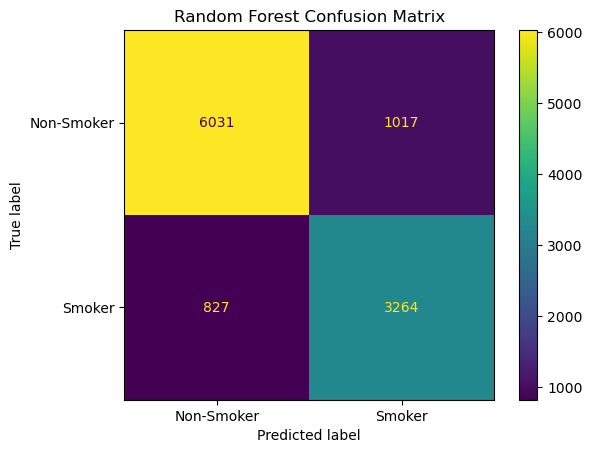

In [31]:
confusion_plot(y_test, rf_clf_pred, rf_clf, title="Random Forest Confusion Matrix")

* Confusion matrix visualizes the prediction of random forest model as in which, there are more samples from Non-Smoker class predicted as smoker compare to smoker class
* It can be also seen that model is good in predicting non-smokers while in total we have (6031+1017) non-smokers and 6031 of them are predicted correctly.

Which feature(s) is the most important one?

In [32]:
sig_features = pd.DataFrame({'feature': X_train.columns, 'importance(%)': rf_clf.feature_importances_*100})
sig_features = sig_features.sort_values('importance(%)', ascending=False)
sig_features

,feature,importance(%)
0,female,8.47
1,male,8.36
24,gtp,7.67
19,hemoglobin,6.98
16,triglyceride,6.11
5,height(cm),5.07
7,waist(cm),4.76
18,ldl,4.71
15,cholesterol,4.55
23,alt,4.54


In [33]:
px.line(sig_features, x='feature', y='importance(%)', title="Feature importance for random forest (Sorted: from the highest to lowest)")

* On the random forest, "Gender" feature has the most impact on the prediction. According to reports [3], men are smoking more than women in the real world. But this does not mean that our model learn this fact. However by confidence, this fact is met due to number of females in the dataset who are not smoking.
* First two columns, as defined in X_train, are 'Female' and 'Male' columns respectively. Therefore, gender is an important feature in prediction.
* After gender, 'GTP',  and 'Hemoglobin' are features with the most importance in prediction.
* Features such as hearing, urine protein, and tartar have less effect on prediction. 

## 2. K-Nearest Neighbor

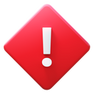

In [34]:
# Make pipeline for hyper parameter tuning
pipe_kn_hp = make_pipe(estimator=neighbors.KNeighborsClassifier(n_jobs=CPU_KILLER), scalar=MinMaxScaler())

# Setting parameters to be tunned
params = [
    {'estimator__n_neighbors': [x for x in range(3, 16, 4)], 
     'estimator__weights': ['uniform', 'distance'],
     'estimator__p': [x for x in range(2, 5)]}
]

# Running GridSearchCV 
grid_kn, result_kn = hyper_params(estimator=pipe_kn_hp, params=params, features=X_train, labels=y_train, indicator='f1_macro')
result_kn = result_kn.set_index(['param_estimator__n_neighbors', 'param_estimator__p', 'param_estimator__weights'])
result_kn

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best Parameters:  {'estimator__n_neighbors': 15, 'estimator__p': 2, 'estimator__weights': 'distance'}
Best Score (f1_macro):  0.7748829433421391


mean_test_accuracy  \
param_estimator__n_neighbors param_estimator__p param_estimator__weights                       
3                            2                  uniform                                 0.73   
                                                distance                                0.77   
                             3                  uniform                                 0.73   
                                                distance                                0.77   
                             4                  uniform                                 0.73   
                                                distance                                0.77   
7                            2                  uniform                                 0.73   
                                                distance                                0.78   
                             3                  uniform                                 0.73   
                                                distance                                0.78   
                             4                  uniform                                 0.73   
                                                distance                                0.78   
11                           2                  uniform                                 0.73   
                                                distance                                0.79   
                             3                  uniform                                 0.73   
                                                distance                                0.79   
                             4                  uniform                                 0.73   
                                                distance                                0.78   
15                           2                  uniform                                 0.73   
                                                distance                                0.79   
                             3                  uniform                                 0.73   
                                                distance                                0.79   
                             4                  uniform                                 0.73   
                                                distance                                0.79   

                                                                          std_test_accuracy  \
param_estimator__n_neighbors param_estimator__p param_estimator__weights                      
3                            2                  uniform                                0.00   
                                                distance                               0.01   
                             3                  uniform                                0.00   
                                                distance                               0.01   
                             4                  uniform                                0.00   
                                                distance                               0.01   
7                            2                  uniform                                0.01   
                                                distance                               0.00   
                             3                  uniform                                0.00   
                                                distance                               0.01   
                             4                  uniform                                0.00   
                                                distance                               0.01   
11                           2                  uniform                                0.01   
                                                distance                               0.00   
                             3                  uniform  

* The same methods implemented for K-Nearest Neighbors. 
* Parameters return via GridSearchCv for this method are 
    - n_neighbors: representing how many neighbors will be involved in the prediction voting. Values used (3, 7, 11, 15)
    - weights: to assign weight or not assigning based on the distance of the test data to the neighbor (if distance is used.)
    - p: used for defining the power of Minkowski function. Values of (2, 3, 4) are used. 
* Limitation: Using GridSearchCV takes longer time with KNN. Therefore, parameters to check are limited to smaller amount

Results of the best classifier

In [35]:
best_res_kn = pd.DataFrame(result_kn.loc[15, 2, 'distance']).reset_index()
best_res_kn.columns = ['metric', 'value']
best_res_kn

,metric,value
0,mean_test_accuracy,0.79
1,std_test_accuracy,0.01
2,rank_test_accuracy,1.00
3,mean_test_balanced_accuracy,0.78
4,std_test_balanced_accuracy,0.00
5,rank_test_balanced_accuracy,1.00
6,mean_test_f1_macro,0.77
7,std_test_f1_macro,0.01
8,rank_test_f1_macro,1.00
9,mean_test_recall,0.72


### Training the model

In [36]:
kn_clf = neighbors.KNeighborsClassifier(n_neighbors=15, p=2, weights='distance')
kn_clf.fit(X_train_sc, y_train)
kn_clf_pred = kn_clf.predict(X_test_sc)
kn_eval = evaluation_metrics(y_test, kn_clf_pred)
kn_eval

{'Accuracy': 0.813,
 'Balanced accuracy': 0.799,
 'F1 score': 0.746,
 'Precision': 0.744,
 'Recall': 0.747}

* Looking at the metrics, specially F1 score, we can say that the model is still doing good in prediction. 
* We can also see that precision and recall values are above 74% which is acceptable.
* Compare to Random Forest, KNN is not performing well. 
* Possible further investigation: Trying other values specially for n_neighbors 

Confusion Matrix

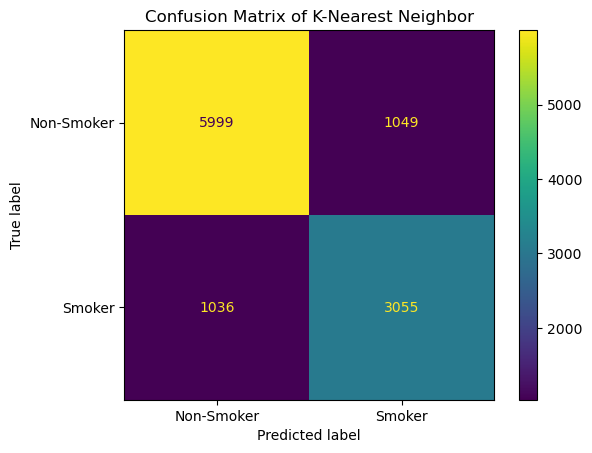

In [37]:
confusion_plot(y_test, kn_clf_pred, kn_clf, title='Confusion Matrix of K-Nearest Neighbor')

* KNN predicts most of the dataset correctly. The performance is acceptable. But it should be mentioned that compare to Random forest this model is not predicting smokers as good as the random forest. This can be seen from the confusion matrix where 1036 smokers are predicted as non-smoker.

## 3. Gaussian Naive Bays

* Gaussian Naive Bays does not have any specific hyper-parameter to tune. Therefore, it can be implemented directly.

In [38]:
gnb_clf = GaussianNB()
gnb_clf.fit(X_train_sc, y_train)
gnb_clf_pred = gnb_clf.predict(X_test_sc)
gnb_eval = evaluation_metrics(y_test, gnb_clf_pred)
gnb_eval

{'Accuracy': 0.711,
 'Balanced accuracy': 0.746,
 'F1 score': 0.691,
 'Precision': 0.569,
 'Recall': 0.879}

* The results of this model are okay. F1 score of 69% is not bad. However, this model has lower precision value. This means that model is not accurately predicting classes and there are some misclassifications in the data.
* In another word, there are fewer predictions identified as class X are actually belonging to class X.
* Because of very good value of Recall (metrics of elements of class X that are predicted as class X) value, f1 score is increased to close to 70.
* This model in general is okay but compare to the other 2 models, it is failed.

Confusion Matrix

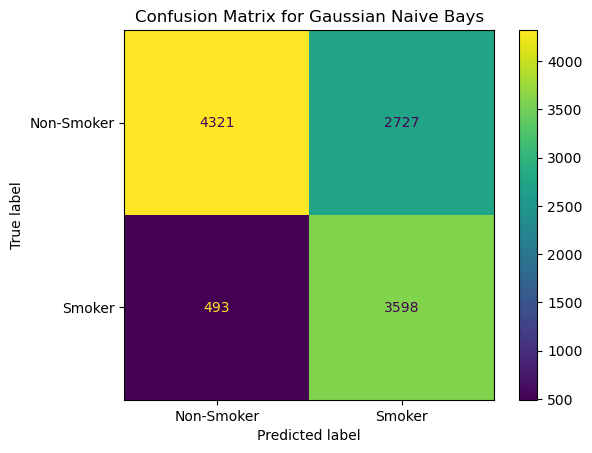

In [39]:
confusion_plot(y_test, gnb_clf_pred, gnb_clf, title="Confusion Matrix for Gaussian Naive Bays")

* Unlike the other models, Gaussian Naive Bays is performing better in identifying "Smokers".
* Confusion matrix shows that there are fewer number of smokers identified as non-smoker. 
* However, we can see that there are also more non-smokers predicted as smoker.

# Conclusion

- According to the scenario, cost of identifying smoker as non-smoker is higher. This because of differentiation in treatments of these to groups in hospital.
- In this case, two models will be good for usage. Random Forest and Naive Bays.
- At this point we can say that Naive bays would be used in extremely critical situations and Random forest might used in less critical situation. 
- This categorization of these two classifiers are actually done regarding to other metrics.
- Random Forest is more likely to identify person correctly however the it's mistakes compare to Naive Bays is more distributed over two classes. 
- While Naive Bays mistakes is more placed in identifying non-smokers as smokers.

# References
1. Dataset: 
     * Kaggle: https://www.kaggle.com/datasets/kukuroo3/body-signal-of-smoking
     * Original: https://www.data.go.kr/data/15007122/fileData.do
2. Lazypredict class documentation: https://lazypredict.readthedocs.io/en/stable/readme.html
3. https://nida.nih.gov/publications/research-reports/tobacco-nicotine-e-cigarettes/are-there-gender-differences-in-tobacco-smoking